In [1]:
# the following code is based on code provided in the article
# https://towardsdatascience.com/facial-keypoints-detection-deep-learning-737547f73515
# I have converted it into pytorch however because I prefer pytorch

In [296]:
import random

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [10]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [30]:
test_csv = pd.read_csv('data/test.csv')
train_csv = pd.read_csv('data/training.csv')

train_csv['Image'] = train_csv['Image'].apply(lambda im: np.fromstring(im, sep=' '))
test_csv['Image'] = test_csv['Image'].apply(lambda im: np.fromstring(im, sep=' '))
train_csv = train_csv.dropna()
test_csv = test_csv.dropna()

### Load the train and test data into a pytorch-friendly format

In [355]:
#display(train_csv)

X_train = np.vstack(train_csv['Image'].values) / 255
X_train = torch.tensor(X_train).float()
X_train = X_train.reshape(-1, 1, 96, 96)

y_train = train_csv[train_csv.columns[:-1]].values
y_train = (y_train - 48) / 48
y_train = torch.tensor(y_train).float()

X_test = np.vstack(test_csv['Image'].values) / 255
X_test = torch.tensor(X_test).float()
X_test = X_test.reshape(-1, 1, 96, 96)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)


torch.Size([2140, 1, 96, 96])
torch.Size([2140, 30])
torch.Size([1783, 1, 96, 96])


### Perform random transformation on the images

In [356]:
image_number = 1002

all_rotated_features = []
all_rotated_images = []

for original_image, original_features in list(zip(X_train, y_train)):
    
    #create the random rotation matrix for the attributes
    theta = random.random() * 3 - 1.5 #random rotation between -1.5 and 1.5 radians
    c, s = np.cos(-theta), np.sin(-theta)
    feature_rotator = np.array(((c, -s), (s, c)))

    #get the features from the original image and rotate them
    features = original_features.reshape(15, 2)
    rotated_features = np.dot(feature_rotator, features.T).T
    rotated_features = rotated_features * 48 + 48

    #get the original image and rotate it
    image = original_image.reshape(96, 96)
    image = image.numpy() * 255
    image_rotator = cv2.getRotationMatrix2D((48, 48), np.degrees(theta), 1.0)
    rotated_image = cv2.warpAffine(image, image_rotator, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    #transform the features into a format consistant with the original data
    rotated_features = rotated_features.flatten()
    rotated_features = (rotated_features - 48) / 48
    rotated_features = torch.tensor(rotated_features).float()

    #transform the images into a format consistant with the original data
    rotated_image = np.vstack(rotated_image) / 255
    rotated_image = torch.tensor(rotated_image).float()
    rotated_image = rotated_image.reshape(1, 96, 96)

    all_rotated_features.append(rotated_features)
    all_rotated_images.append(rotated_image)
    
print(rotated_features.shape)
print(rotated_image.shape)

#append the modifed data to the original data
X_train = torch.cat((X_train, torch.stack(all_rotated_images)))
y_train = torch.cat((y_train, torch.stack(all_rotated_features)))

print(X_train.shape)
print(y_train.shape)

trainset = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=50, shuffle=True)


torch.Size([30])
torch.Size([1, 96, 96])
torch.Size([4280, 1, 96, 96])
torch.Size([4280, 30])


In [357]:
#convert the split set into a form that can be used by the neural network more easily


class FacialFeatureDetectionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
    
    
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.flat1 = nn.Flatten()
        
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)
        self.drop3 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 30)

    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = self.drop2(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool1(x)
        x = self.drop3(x)
        
        x = self.flat1(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    

net = FacialFeatureDetectionNetwork()
print(net)

FacialFeatureDetectionNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=30, bias=True)
)


In [365]:
net = FacialFeatureDetectionNetwork()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(0, 1):
    for data in trainset: 
        X, y = data 
        net.zero_grad()

        #print(X.shape, y.shape)

        output = net(X)
        #print(output.shape)
        #print(output.reshape(-1, 1).shape)

        loss = F.mse_loss(output, y)
        loss.backward()

        print(loss)

        optimizer.step() 


tensor(0.1631, grad_fn=<MseLossBackward>)
tensor(36.7202, grad_fn=<MseLossBackward>)
tensor(0.1530, grad_fn=<MseLossBackward>)
tensor(0.1608, grad_fn=<MseLossBackward>)
tensor(0.1634, grad_fn=<MseLossBackward>)
tensor(0.1699, grad_fn=<MseLossBackward>)
tensor(0.1888, grad_fn=<MseLossBackward>)
tensor(0.1613, grad_fn=<MseLossBackward>)
tensor(0.1500, grad_fn=<MseLossBackward>)
tensor(0.1292, grad_fn=<MseLossBackward>)
tensor(0.0906, grad_fn=<MseLossBackward>)
tensor(0.0759, grad_fn=<MseLossBackward>)
tensor(0.0795, grad_fn=<MseLossBackward>)
tensor(0.0634, grad_fn=<MseLossBackward>)
tensor(0.0766, grad_fn=<MseLossBackward>)
tensor(0.0512, grad_fn=<MseLossBackward>)
tensor(0.0601, grad_fn=<MseLossBackward>)
tensor(0.0516, grad_fn=<MseLossBackward>)
tensor(0.0418, grad_fn=<MseLossBackward>)
tensor(0.0454, grad_fn=<MseLossBackward>)
tensor(0.0576, grad_fn=<MseLossBackward>)
tensor(0.0474, grad_fn=<MseLossBackward>)
tensor(0.0512, grad_fn=<MseLossBackward>)
tensor(0.0384, grad_fn=<MseLossBa

In [366]:
X_test
y_test = net(X_test)


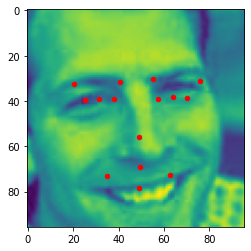

In [367]:

image_number = 1002

image = X_test[image_number].reshape(96, 96)
image = image.numpy()
image = image * 255


features = y_test[image_number].reshape(15, 2)
features = features.detach().numpy()
features = features * 48 
features = features + 48


#print(image.shape)
#print(image)
#print(features)
plt.scatter(features[:, 0], features[:, 1], c='r', s=20)
plt.imshow(image)
